<a href="https://colab.research.google.com/github/setiyailmi/group-07-fp-sml/blob/main/group_07_fp_sml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scrapping Data Grab

In [ ]:
# SCRAPING GOOGLE PLAY - GRAB PASSENGER

!pip install google-play-scraper pandas openpyxl

from google_play_scraper import reviews, Sort
import pandas as pd

# App ID Grab Passenger
app_id = 'com.grabtaxi.passenger'  # ❗

# Ambil review dalam batch
all_reviews = []
token = None

for i in range(5):  # Ambil maksimal 5000 review
    print(f"Mengambil batch ke-{i+1} ...")
    result, token = reviews(
        app_id,
        lang='id',         # Bahasa Indonesia
        country='id',      # Region Indonesia
        sort=Sort.NEWEST,  # Urutkan terbaru
        count=1000,        # Jumlah per batch
        continuation_token=token
    )
    all_reviews.extend(result)
    if not token:
        break

print(f"Total review terkumpul: {len(all_reviews)}")

# Konversi ke DataFrame
df = pd.DataFrame(all_reviews)

# Cek kolom dan contoh data
print("\nKolom yang tersedia:", df.columns.tolist())
display(df.head())

# SIMPAN KE FILE EXCEL
output_path = "grab_passenger_reviews.xlsx"
df.to_excel(output_path, index=False)

print(f"\nData berhasil disimpan ke file: {output_path}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
Mengambil batch ke-1 ...
Mengambil batch ke-2 ...
Mengambil batch ke-3 ...
Mengambil batch ke-4 ...
Mengambil batch ke-5 ...
Total review terkumpul: 5000

Kolom yang tersedia: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion']


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1d90aae2-725b-4f08-a5fc-1441e468211b,Eka Tasya,https://play-lh.googleusercontent.com/a/ACg8oc...,saya suka aplikasi ini karena sesuai dengan pe...,5,0,5.387.1,2025-12-16 14:35:02,None,NaT,5.387.1
1,2dece897-89bf-4e89-aa20-a0d1555bd3b5,Leonard Ryo Martadi,https://play-lh.googleusercontent.com/a-/ALV-U...,"driver bintang 5 gk menjamin driver bagus, ban...",1,0,5.387.1,2025-12-16 14:31:58,Halo Kak. Maaf ya buat enggak nyaman 🙇‍♀️\nApa...,2025-12-17 07:33:01,5.387.1
2,a1017b05-2d79-4b7e-aaf9-10f1fc85f70d,Muhammad Nuhbanu,https://play-lh.googleusercontent.com/a/ACg8oc...,"pengemudi ramah dan sopan, aman dan nyaman sel...",5,0,5.387.1,2025-12-16 14:28:34,None,NaT,5.387.1
3,97fd1a47-6602-4d34-94f1-d8a13a8b33be,DENI RUSTIAWAN,https://play-lh.googleusercontent.com/a/ACg8oc...,mantap,5,0,5.387.1,2025-12-16 14:25:23,None,NaT,5.387.1
4,2ecba258-dea1-4e83-9881-2a6da3f4d7b3,Muhammad Aldi Rizqillah,https://play-lh.googleusercontent.com/a-/ALV-U...,Pengalaman Menggunakan Grab Mobil Dari Stasiun...,5,0,None,2025-12-16 14:16:30,None,NaT,None



Data berhasil disimpan ke file: grab_passenger_reviews.xlsx


NusaBERT Text Embeddings and Emoji Sentiment Features

In [ ]:
pip install pandas numpy scikit-learn transformers torch emoji tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import torch
from transformers import AutoTokenizer, AutoModel
import emoji

In [ ]:
# PATH DATASET
DATA_PATH = "/content/grab_passenger_reviews.xlsx"

df = pd.read_excel(DATA_PATH)

# Pastikan kolom konten ada
TEXT_COL = "content"
assert TEXT_COL in df.columns, f"Kolom '{TEXT_COL}' tidak ditemukan. Kolom yang ada: {list(df.columns)}"

df = df.dropna(subset=[TEXT_COL]).copy()
df[TEXT_COL] = df[TEXT_COL].astype(str)
print(df.shape)
df.head()

(5000, 11)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,e1399f50-4b66-42d6-bced-91ec21e4b72b,Ros Tiani,https://play-lh.googleusercontent.com/a/ACg8oc...,kenapa saldo paylater saya hilang ya 🥹🥹,1,0,5.381.0,2025-10-29 04:02:30,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2025-10-29 05:21:57,5.381.0
1,b03545b5-ea3f-4ed7-988e-ab4e592b35ea,Choirun nisak Anis,https://play-lh.googleusercontent.com/a/ACg8oc...,driver ramah dan sabar,5,0,5.380.0,2025-10-29 04:01:16,NaN,NaT,5.380.0
2,f3298bc7-ced2-4244-a36c-ee0d19293c31,Maxisoft & Mutimedia,https://play-lh.googleusercontent.com/a-/ALV-U...,sesat,1,0,NaN,2025-10-29 03:50:17,Maaf ya atas ketidaknyamanan yang terjadi.\nKa...,2025-10-29 05:22:00,NaN
3,ab52ed29-ae5b-45d3-8fc1-1fd2222c8dec,Rohim RR,https://play-lh.googleusercontent.com/a-/ALV-U...,jossss,5,0,5.380.0,2025-10-29 03:35:47,NaN,NaT,5.380.0
4,92d57d37-781a-4acc-8e45-22e79b971260,Anton Priyogo,https://play-lh.googleusercontent.com/a/ACg8oc...,mantap,5,0,5.381.0,2025-10-29 03:18:55,NaN,NaT,5.381.0


In [ ]:
# simpan raw
df["content_raw"] = df[TEXT_COL].astype(str)

slang_dict = {
    # Indonesia umum
    "yg": "yang",
    "ga": "tidak", "gk": "tidak", "ngga": "tidak", "gak": "tidak", "nggak": "tidak", "enggak": "tidak",
    "udah": "sudah", "udh": "sudah", "dah": "sudah", "sdh": "sudah",
    "kalo": "kalau", "klo": "kalau",
    "aja": "saja", "pake": "pakai",
    "tp": "tapi", "tpi": "tapi",
    "tdk": "tidak",
    "byr": "bayar",
    "slah":"salah",
    "sy": "saya", "sya": "saya", "aku": "saya", "gw": "saya", "gua": "saya",
    "jg": "juga", "jd": "jadi", "lg": "lagi", "lgi": "lagi",
    "trus": "terus", "trs": "terus",
    "blm": "belum", "knp": "kenapa", "krn": "karena",
    "org": "orang", "bs": "bisa", "dpt": "dapat",
    "apk": "aplikasi", "app": "aplikasi",
    "bgt": "banget", "bgus": "bagus",
    "eror": "error", "greb": "grab",
    "mantaf": "mantap",
    "utk": "untuk",

    # Jawa umum
    "ora": "tidak", "ra": "tidak", "mboten": "tidak", "ndak": "tidak",
    "iso": "bisa", "isa": "bisa",
    "wes": "sudah", "uwes": "sudah",
    "opo": "apa", "piye": "bagaimana", "ngopo": "kenapa",
    "karo": "dengan",
}

def normalize_text(text: str) -> str:
    text = str(text).lower()

    # hapus URL
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # untuk versi clean text yang ada emoji, emoji dihapus (raw tetap ada)
    text = emoji.replace_emoji(text, replace=" ")

    # normalisasi slang (pakai boundary)
    for slang in sorted(slang_dict, key=len, reverse=True):
        text = re.sub(rf"\b{re.escape(slang)}\b", slang_dict[slang], text)

    # hapus karakter aneh (biarkan huruf/angka/spasi)
    text = re.sub(r"[^0-9a-zA-Z\u00C0-\u024F\u1E00-\u1EFF\s]", " ", text)

    # rapikan spasi
    text = re.sub(r"\s+", " ", text).strip()

    # reduksi huruf berulang
    text = re.sub(r"([a-z])\1{2,}", r"\1", text)

    return text

df["text_clean"] = df["content_raw"].apply(normalize_text)
df[["content_raw", "text_clean"]].head(10)

,content_raw,text_clean
0,kenapa saldo paylater saya hilang ya 🥹🥹,kenapa saldo paylater saya hilang ya
1,driver ramah dan sabar,driver ramah dan sabar
2,sesat,sesat
3,jossss,jos
4,mantap,mantap
5,"Ini kenapa yah kok saya baru byr ovo paylater,...",ini kenapa yah kok saya baru bayar ovo paylate...
6,mantap cepet banget dan nyaman,mantap cepet banget dan nyaman
7,👍👍👍👍👍👍,
8,ok,ok
9,sangat memuaskan dengan waktu 6 mnit armada si...,sangat memuaskan dengan waktu 6 mnit armada si...


In [ ]:
categories = {
    "delay_waiting_cancellation": [
        "lama", "telat", "nunggu", "menunggu", "cancel", "dibatalkan","jauh",
        "tidak bisa cancel", "gak dapet driver", "posisi driver jauh","tidak dapat driver"
    ],

    "driver_attitude_integrity": [
        "tidak sopan", "kasar", "nyasar", "marah", "ancam","gak sopan","gajelas","aneh","hujan","tidak dilayanin",
        "minta uang tambahan", "uang parkir", "nakal", "manja", "driver bingung","galak"
    ],

    "payment_refund_subscription": [
        "saldo", "terpotong", "refund", "uang tidak kembali","tidak guna ovonya",
        "langganan", "paylater", "transaksi gagal","sudah dibayar","pembayaran gagal",
        "limit", "perbaiki link pembayaran","jatuh tempo"
    ],

    "app_system_bug_ux": [
        "error", "bug", "lemot", "perbaiki maps","tidak bisa login","ngaco", "pin lokasi salah", "lokasi melenceng",
        "maps tidak akurat","hp produksi awal","kode tidak masuk","double verification", "otp", "verifikasi wajah",
        "peta error", "map error", "aplikasi geblek","tolong diperbaiki","sulit","tidak bisa dibatalkan","gps"
    ],

    "merchant_order_content": [
        "resto tutup", "pesanan kurang", "salah pesanan",
        "makanan dingin","tidak bisa di cancle","menu tidak sesuai"
    ],
    "pricing_fee_policy": [
        "ongkir", "tarif mahal", "biaya tambahan",
        "biaya admin", "harga berubah", "mahal"
    ],
    "policy_safety_suggestion": [
        # driving_safety_route
        "ngebut", "ugal ugalan", "bahaya",
        "jalan memutar", "muter muter", "sesat", "rem mendadak",

        # policy_fairness
        "tidak adil", "kebijakan", "diperas", "potongan besar",

        # feature_request_policy_suggestion
        "saran", "sebaiknya", "harap", "tolong adain",
        "diskon pelajar", "promo pelajar",
        "buat pelajar", "khusus pelajar", "rumah jauh"
    ],
    "positive_feedback": [
        "mantap", "bagus", "cepat", "nyaman", "sesuai","sopan", "membantu","recommend","mudah", "terima kasih",
        "puas", "oke", "ok", "jos", "👍","ramah","memuaskan","good","baik","sabar","sesuai","⭐⭐⭐⭐⭐"
    ]
}

In [ ]:
LABELS_PRIORITY = [
    "payment_refund_subscription",   # uang, saldo, double bayar → paling krusial
    "app_system_bug_ux",              # bug sistem, maps, login, chat
    "delay_waiting_cancellation",     # nunggu lama, cancel, gak dapet driver
    "merchant_order_content",         # resto tutup, salah pesanan
    "driver_attitude_integrity",      # sikap driver
    "policy_safety_suggestion",
    "pricing_fee_policy",             # ongkir, harga mahal
    "positive_feedback"               # pujian (paling akhir)
]

LABEL_MAP = {i: name for i, name in enumerate(LABELS_PRIORITY)}
OTHER_LABEL = len(LABELS_PRIORITY)
LABEL_MAP[OTHER_LABEL] = "other"

KEYWORDS = {i: categories[name] for i, name in enumerate(LABELS_PRIORITY)}

print("LABEL_MAP:", LABEL_MAP)
print("OTHER_LABEL:", OTHER_LABEL)

LABEL_MAP: {0: 'payment_refund_subscription', 1: 'app_system_bug_ux', 2: 'delay_waiting_cancellation', 3: 'merchant_order_content', 4: 'driver_attitude_integrity', 5: 'policy_safety_suggestion', 6: 'pricing_fee_policy', 7: 'positive_feedback', 8: 'other'}
OTHER_LABEL: 8


In [ ]:
def assign_label_rule(text: str) -> int:
    t = str(text).lower()

    for lbl in range(len(LABELS_PRIORITY)):
        for kw in KEYWORDS.get(lbl, []):
            if kw in t:
                return lbl

    return OTHER_LABEL

In [ ]:
df["label_rule"] = df["text_clean"].apply(assign_label_rule)
df["label_name_rule"] = df["label_rule"].map(LABEL_MAP)

df["label_name_rule"].value_counts(dropna=False)

,count
label_name_rule,
positive_feedback,2980
other,1345
delay_waiting_cancellation,339
payment_refund_subscription,106
app_system_bug_ux,99
driver_attitude_integrity,53
pricing_fee_policy,53
policy_safety_suggestion,25


In [ ]:
# kolom yang diexport
export_cols = []
for col in ["reviewId", "userName", "content", "text_clean", "score", "label_rule", "label_name_rule"]:
    if col in df.columns:
        export_cols.append(col)

df_export = df[export_cols].copy()

# BUAT KOLOM UNTUK LABEL FINAL (yang nanti kamu isi manual)
df_export["label_final"] = df_export["label_rule"]
df_export["label_name_final"] = df_export["label_final"].map(LABEL_MAP)

# Simpan
df_export.to_excel("grab_labeling_to_correct.xlsx", index=False)

print("Saved:")
print("- grab_labeling_to_correct.xlsx")

Saved:
- grab_labeling_to_correct.xlsx


In [ ]:
CORRECTED_PATH = "/content/grab_labeling_to_correct.xlsx" #ini excel yg udah di label otomatis sama beberapa label manual
df_corr = pd.read_excel(CORRECTED_PATH)

# pastikan kolom label_final ada
assert "label_final" in df_corr.columns, "Kolom 'label_final' tidak ada. Pastikan kamu sudah koreksi di Excel."

df_corr["label_final"] = df_corr["label_final"].astype(int)
df_corr["label_name_final"] = df_corr["label_final"].map(LABEL_MAP)

print(df_corr["label_name_final"].value_counts(dropna=False))
df_corr.head()

label_name_final
positive_feedback              2980
other                          1294
delay_waiting_cancellation      343
app_system_bug_ux               112
payment_refund_subscription     109
pricing_fee_policy               60
driver_attitude_integrity        59
policy_safety_suggestion         43
Name: count, dtype: int64


,reviewId,userName,content,text_clean,score,label_rule,label_name_rule,label_final,label_name_final
0,e1399f50-4b66-42d6-bced-91ec21e4b72b,Ros Tiani,kenapa saldo paylater saya hilang ya 🥹🥹,kenapa saldo paylater saya hilang ya,1,0,payment_refund_subscription,0,payment_refund_subscription
1,b03545b5-ea3f-4ed7-988e-ab4e592b35ea,Choirun nisak Anis,driver ramah dan sabar,driver ramah dan sabar,5,7,positive_feedback,7,positive_feedback
2,f3298bc7-ced2-4244-a36c-ee0d19293c31,Maxisoft & Mutimedia,sesat,sesat,1,5,policy_safety_suggestion,5,policy_safety_suggestion
3,ab52ed29-ae5b-45d3-8fc1-1fd2222c8dec,Rohim RR,jossss,jos,5,7,positive_feedback,7,positive_feedback
4,92d57d37-781a-4acc-8e45-22e79b971260,Anton Priyogo,mantap,mantap,5,7,positive_feedback,7,positive_feedback


In [ ]:
df_model = df_corr[df_corr["label_name_final"] != "other"].copy()
print(df_model["label_name_final"].value_counts())

label_name_final
positive_feedback              2980
delay_waiting_cancellation      343
app_system_bug_ux               112
payment_refund_subscription     109
pricing_fee_policy               60
driver_attitude_integrity        59
policy_safety_suggestion         43
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_model["y"] = le.fit_transform(df_model["label_name_final"])

print("Mapping label baru:", dict(zip(le.classes_, le.transform(le.classes_))))

Mapping label baru: {'app_system_bug_ux': np.int64(0), 'delay_waiting_cancellation': np.int64(1), 'driver_attitude_integrity': np.int64(2), 'payment_refund_subscription': np.int64(3), 'policy_safety_suggestion': np.int64(4), 'positive_feedback': np.int64(5), 'pricing_fee_policy': np.int64(6)}


In [ ]:
from sklearn.model_selection import train_test_split

idx = np.arange(len(df_model))

idx_train, idx_test = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    stratify=df_model["y"].values
)

X_train_text = df_model.iloc[idx_train]["text_clean"].astype(str).values
X_test_text  = df_model.iloc[idx_test]["text_clean"].astype(str).values

# Emoji harus dari raw
RAW_COL = "content_raw" if "content_raw" in df_model.columns else "content"
X_train_raw = df_model.iloc[idx_train][RAW_COL].astype(str).values
X_test_raw  = df_model.iloc[idx_test][RAW_COL].astype(str).values

y_train = df_model.iloc[idx_train]["y"].values
y_test  = df_model.iloc[idx_test]["y"].values

print("Train:", len(X_train_text), "Test:", len(X_test_text))

Train: 2964 Test: 742


In [ ]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

MODEL_NAME = "LazarusNLP/all-nusabert-base-v4"  # SentenceTransformer NusaBERT [web:27]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

st_model = SentenceTransformer(MODEL_NAME, device=DEVICE)

def st_embeddings(texts, batch_size=64):
    embs = st_model.encode(
        list(texts),
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        device=DEVICE
    )
    return embs

X_train_bert = st_embeddings(X_train_text)
X_test_bert  = st_embeddings(X_test_text)

print("Train NusaBERT:", X_train_bert.shape)
print("Test  NusaBERT:", X_test_bert.shape)

Device: cpu


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Train NusaBERT: (2964, 768)
Test  NusaBERT: (742, 768)


In [ ]:
import emoji

EMOJI_SENTIMENT = {
    # POSITIVE STRONG
    "👍":  1.0,
    "👌":  1.0,
    "😍":  1.0,
    "❤️":  1.0,
    "💯":  1.0,
    "🤩":  1.0,
    "🥰":  1.0,
    "🫶":  1.0,

    # POSITIVE MEDIUM
    "😊":  0.8,
    "😁":  0.8,
    "😃":  0.8,
    "😆":  0.8,
    "😀":  0.7,
    "😎":  0.7,
    "☺️":  0.7,
    "🌟":  0.7,
    "💪🏻": 0.7,
    "🙏":  0.2,

    # POSITIVE MILD
    "🤭":  0.4,
    "😂":  0.5,
    "😅":  0.3,
    "🤤":  0.3,
    "⭐":  0.5,

    # NEGATIVE MILD
    "🥹": -0.2,
    "🥺": -0.4,
    "😕": -0.3,
    "🙁": -0.4,
    "☹️": -0.6,
    "😑": -0.6,

    # NEGATIVE STRONG
    "😢": -0.8,
    "😠": -0.9,
    "😤": -0.9,
    "😡": -1.0,
    "🤬": -1.0,
    "😭": -1.0,
    "💩": -1.0,
    "👎": -1.0,
    "💔": -1.0,
    "🐀":  0.0,
}

def extract_emojis(text: str):
    return [ch for ch in str(text) if ch in emoji.EMOJI_DATA]

def emoji_features(text: str):
    ems = extract_emojis(text)
    if not ems:
        return [0, 0.0, 0.0, 0, 0]

    scores = []
    pos = neg = 0
    for e in ems:
        s = EMOJI_SENTIMENT.get(e, 0.0)
        scores.append(s)
        if s > 0: pos += 1
        elif s < 0: neg += 1

    return [
        len(ems),
        float(np.sum(scores)),
        float(np.mean(scores)) if len(scores) else 0.0,
        pos,
        neg
    ]

X_train_emoji = np.vstack([emoji_features(t) for t in X_train_raw])
X_test_emoji  = np.vstack([emoji_features(t) for t in X_test_raw])

print("Train Emoji:", X_train_emoji.shape)
print("Test  Emoji:", X_test_emoji.shape)

Train Emoji: (2964, 5)
Test  Emoji: (742, 5)


In [ ]:
#Cek berapa % review yang punya emoji
def has_emoji(t):
    return any(ch in emoji.EMOJI_DATA for ch in str(t))

emoji_rate = np.mean([has_emoji(t) for t in df_model[RAW_COL].astype(str).values])
print("Proporsi review yang mengandung emoji:", round(emoji_rate, 4))

Proporsi review yang mengandung emoji: 0.0534


In [ ]:
df_model["has_emoji"] = df_model[RAW_COL].astype(str).apply(has_emoji)
print(pd.crosstab(df_model["label_name_final"], df_model["has_emoji"], normalize="index"))

has_emoji                       False     True 
label_name_final                               
app_system_bug_ux            0.946429  0.053571
delay_waiting_cancellation   0.915452  0.084548
driver_attitude_integrity    0.949153  0.050847
payment_refund_subscription  0.889908  0.110092
policy_safety_suggestion     0.906977  0.093023
positive_feedback            0.953356  0.046644
pricing_fee_policy           0.916667  0.083333


In [ ]:
X_train_combined = np.hstack([X_train_bert, X_train_emoji])
X_test_combined  = np.hstack([X_test_bert,  X_test_emoji])

print("Train Combined:", X_train_combined.shape)
print("Test  Combined:", X_test_combined.shape)

Train Combined: (2964, 773)
Test  Combined: (742, 773)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_and_eval(Xtr, Xte, ytr, yte, title="", balanced=True):
    cw = "balanced" if balanced else None

    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(
            max_iter=2000,
            multi_class="multinomial",
            solver="lbfgs",
            class_weight=cw
        ))
    ])

    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    acc = accuracy_score(yte, pred)

    print("\n" + "="*70)
    print(f"EXPERIMENT: {title} | class_weight={cw}")
    print("Accuracy:", round(acc, 4))
    print(classification_report(yte, pred, target_names=le.classes_, zero_division=0))

    # CONFUSION MATRIX
    cm = confusion_matrix(yte, pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=le.classes_
    )
    disp.plot(
        cmap="Blues",
        values_format="d"
    )
    plt.title(f"Confusion Matrix – {title}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return pipe, acc

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



EXPERIMENT: NusaBERT ONLY | class_weight=balanced
Accuracy: 0.8962
                             precision    recall  f1-score   support

          app_system_bug_ux       0.59      0.59      0.59        22
 delay_waiting_cancellation       0.70      0.77      0.73        69
  driver_attitude_integrity       0.38      0.50      0.43        12
payment_refund_subscription       0.75      0.82      0.78        22
   policy_safety_suggestion       0.23      0.38      0.29         8
          positive_feedback       0.98      0.94      0.96       597
         pricing_fee_policy       0.63      1.00      0.77        12

                   accuracy                           0.90       742
                  macro avg       0.61      0.71      0.65       742
               weighted avg       0.91      0.90      0.90       742



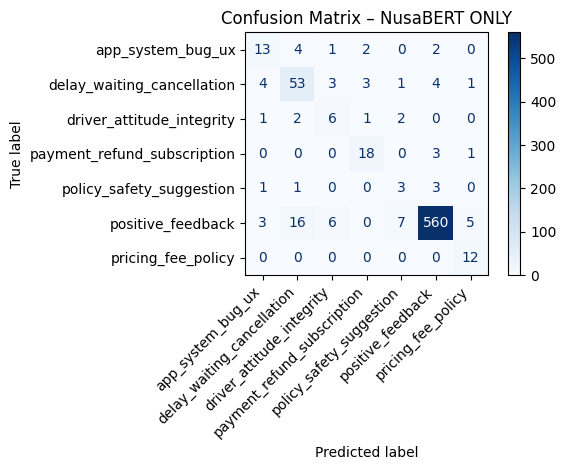

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



EXPERIMENT: Emoji ONLY | class_weight=balanced
Accuracy: 0.0431
                             precision    recall  f1-score   support

          app_system_bug_ux       0.00      0.00      0.00        22
 delay_waiting_cancellation       0.11      0.01      0.03        69
  driver_attitude_integrity       0.02      0.92      0.03        12
payment_refund_subscription       0.00      0.00      0.00        22
   policy_safety_suggestion       0.00      0.00      0.00         8
          positive_feedback       0.90      0.03      0.06       597
         pricing_fee_policy       0.50      0.08      0.14        12

                   accuracy                           0.04       742
                  macro avg       0.22      0.15      0.04       742
               weighted avg       0.75      0.04      0.05       742



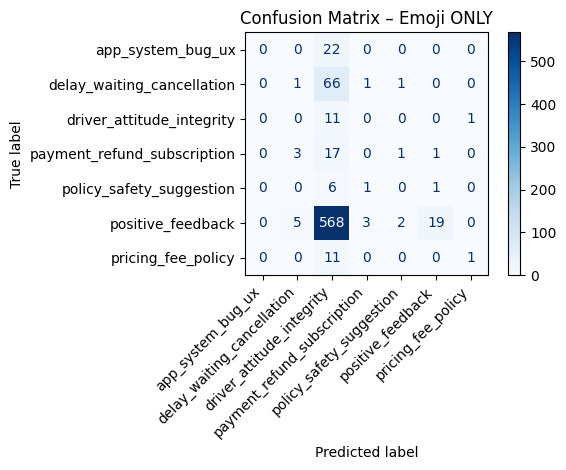

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



EXPERIMENT: NusaBERT + Emoji (COMBINED) | class_weight=balanced
Accuracy: 0.8976
                             precision    recall  f1-score   support

          app_system_bug_ux       0.59      0.59      0.59        22
 delay_waiting_cancellation       0.70      0.78      0.74        69
  driver_attitude_integrity       0.38      0.50      0.43        12
payment_refund_subscription       0.78      0.82      0.80        22
   policy_safety_suggestion       0.17      0.25      0.20         8
          positive_feedback       0.98      0.94      0.96       597
         pricing_fee_policy       0.63      1.00      0.77        12

                   accuracy                           0.90       742
                  macro avg       0.60      0.70      0.64       742
               weighted avg       0.91      0.90      0.90       742



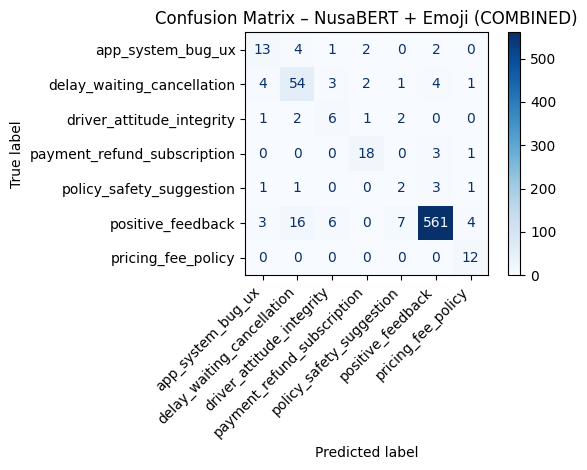

,Model,Accuracy,Class Weight
0,Emoji Only,0.043127,Balanced
1,NusaBERT Only,0.896226,Balanced
2,Combined,0.897574,Balanced


In [ ]:
# class_weight balanced
model_bert, acc_bert = train_and_eval(
    X_train_bert, X_test_bert, y_train, y_test,
    title="NusaBERT ONLY", balanced=True
)

model_emoji, acc_emoji = train_and_eval(
    X_train_emoji, X_test_emoji, y_train, y_test,
    title="Emoji ONLY", balanced=True
)

model_combined, acc_combined = train_and_eval(
    X_train_combined, X_test_combined, y_train, y_test,
    title="NusaBERT + Emoji (COMBINED)", balanced=True
)

results_bal = pd.DataFrame({
    "Model": ["Emoji Only", "NusaBERT Only", "Combined"],
    "Accuracy": [acc_emoji, acc_bert, acc_combined],
    "Class Weight": ["Balanced"]*3
})
results_bal

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



EXPERIMENT: NusaBERT ONLY | class_weight=None
Accuracy: 0.9084
                             precision    recall  f1-score   support

          app_system_bug_ux       0.59      0.59      0.59        22
 delay_waiting_cancellation       0.74      0.78      0.76        69
  driver_attitude_integrity       0.45      0.42      0.43        12
payment_refund_subscription       0.77      0.77      0.77        22
   policy_safety_suggestion       0.38      0.38      0.38         8
          positive_feedback       0.97      0.96      0.96       597
         pricing_fee_policy       0.64      0.75      0.69        12

                   accuracy                           0.91       742
                  macro avg       0.65      0.66      0.66       742
               weighted avg       0.91      0.91      0.91       742



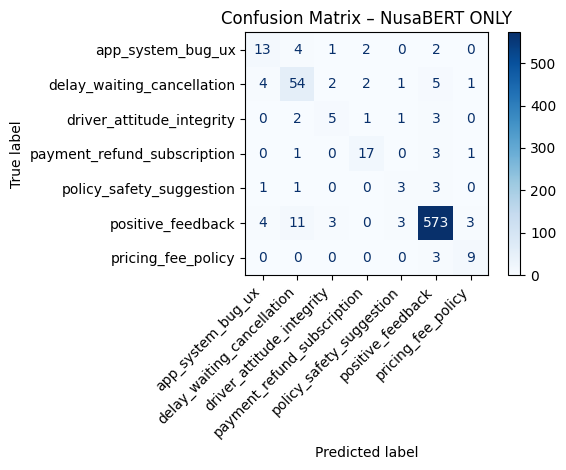

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



EXPERIMENT: Emoji ONLY | class_weight=None
Accuracy: 0.8046
                             precision    recall  f1-score   support

          app_system_bug_ux       0.00      0.00      0.00        22
 delay_waiting_cancellation       0.20      0.01      0.03        69
  driver_attitude_integrity       0.00      0.00      0.00        12
payment_refund_subscription       0.00      0.00      0.00        22
   policy_safety_suggestion       0.00      0.00      0.00         8
          positive_feedback       0.81      1.00      0.89       597
         pricing_fee_policy       0.00      0.00      0.00        12

                   accuracy                           0.80       742
                  macro avg       0.14      0.14      0.13       742
               weighted avg       0.67      0.80      0.72       742



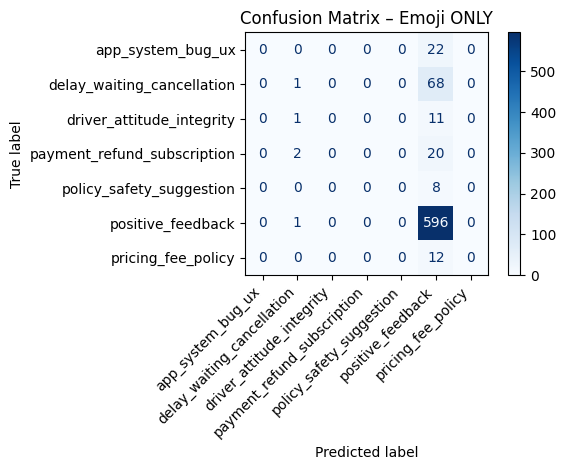

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



EXPERIMENT: NusaBERT + Emoji (COMBINED) | class_weight=None
Accuracy: 0.9124
                             precision    recall  f1-score   support

          app_system_bug_ux       0.60      0.55      0.57        22
 delay_waiting_cancellation       0.74      0.81      0.77        69
  driver_attitude_integrity       0.45      0.42      0.43        12
payment_refund_subscription       0.79      0.86      0.83        22
   policy_safety_suggestion       0.43      0.38      0.40         8
          positive_feedback       0.97      0.96      0.96       597
         pricing_fee_policy       0.75      0.75      0.75        12

                   accuracy                           0.91       742
                  macro avg       0.68      0.67      0.67       742
               weighted avg       0.91      0.91      0.91       742



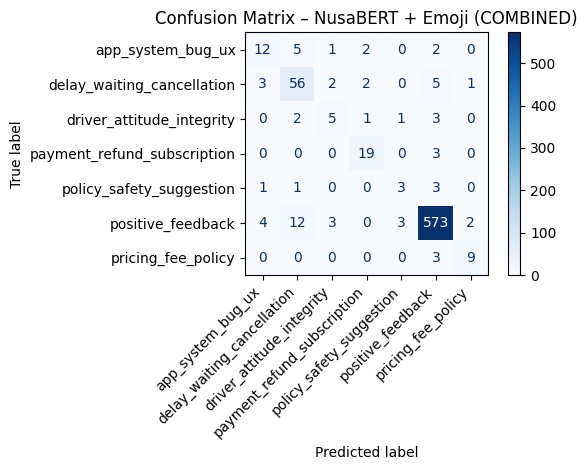

In [ ]:
# tanpa class_weight
model_bert_none, acc_bert_none = train_and_eval(
    X_train_bert, X_test_bert, y_train, y_test,
    title="NusaBERT ONLY", balanced=False
)

model_emoji_none, acc_emoji_none = train_and_eval(
    X_train_emoji, X_test_emoji, y_train, y_test,
    title="Emoji ONLY", balanced=False
)

model_combined_none, acc_combined_none = train_and_eval(
    X_train_combined, X_test_combined, y_train, y_test,
    title="NusaBERT + Emoji (COMBINED)", balanced=False
)

In [ ]:
results_none = pd.DataFrame({
    "Model": ["Emoji Only", "NusaBERT Only", "Combined"],
    "Accuracy": [acc_emoji_none, acc_bert_none, acc_combined_none],
    "Class Weight": ["None"]*3
})

results = pd.concat([results_bal, results_none], ignore_index=True)
results.sort_values(["Model", "Class Weight"])

,Model,Accuracy,Class Weight
2,Combined,0.897574,Balanced
5,Combined,0.912399,None
0,Emoji Only,0.043127,Balanced
3,Emoji Only,0.804582,None
1,NusaBERT ST Only,0.896226,Balanced
4,NusaBERT ST Only,0.908356,None


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



EXPERIMENT: Best Model (Combined, No Class Weight) | class_weight=None
Accuracy: 0.9124
                             precision    recall  f1-score   support

          app_system_bug_ux       0.60      0.55      0.57        22
 delay_waiting_cancellation       0.74      0.81      0.77        69
  driver_attitude_integrity       0.45      0.42      0.43        12
payment_refund_subscription       0.79      0.86      0.83        22
   policy_safety_suggestion       0.43      0.38      0.40         8
          positive_feedback       0.97      0.96      0.96       597
         pricing_fee_policy       0.75      0.75      0.75        12

                   accuracy                           0.91       742
                  macro avg       0.68      0.67      0.67       742
               weighted avg       0.91      0.91      0.91       742



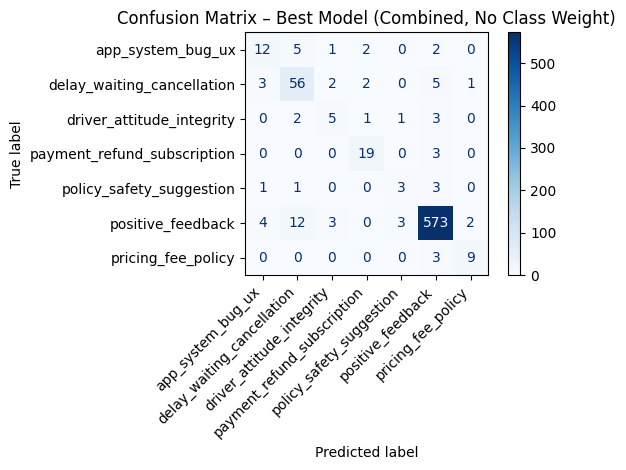

In [ ]:
model_combined_none, acc_combined_none = train_and_eval(
    X_train_combined, X_test_combined, y_train, y_test,
    title="Best Model (Combined, No Class Weight)", balanced=False
)